In [0]:
import os
import cv2
import numpy as np
import random
from PIL import Image
from PIL import ImageOps
import pandas as pd 
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from google.colab import drive
import seaborn as sns
import matplotlib.image as mimg
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
np.random.seed(1000)
#new layers end here
print(os.listdir("/content/gdrive/My Drive/demo/chest_xray/chest_xray"))

['.DS_Store', 'test', 'val', 'train']


In [0]:
# Define path to the data directory
data_dir = Path('/content/gdrive/My Drive/demo/chest_xray/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [0]:
#PNEUMONIA: This directory contains those samples that are the pneumonia cases.
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/content/gdrive/My Drive/demo/chest_xray/chest...,0
1,/content/gdrive/My Drive/demo/chest_xray/chest...,1
2,/content/gdrive/My Drive/demo/chest_xray/chest...,0
3,/content/gdrive/My Drive/demo/chest_xray/chest...,1
4,/content/gdrive/My Drive/demo/chest_xray/chest...,0


1    3875
0    1341
Name: label, dtype: int64


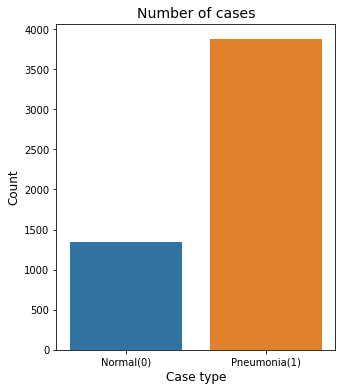

In [0]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,6))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

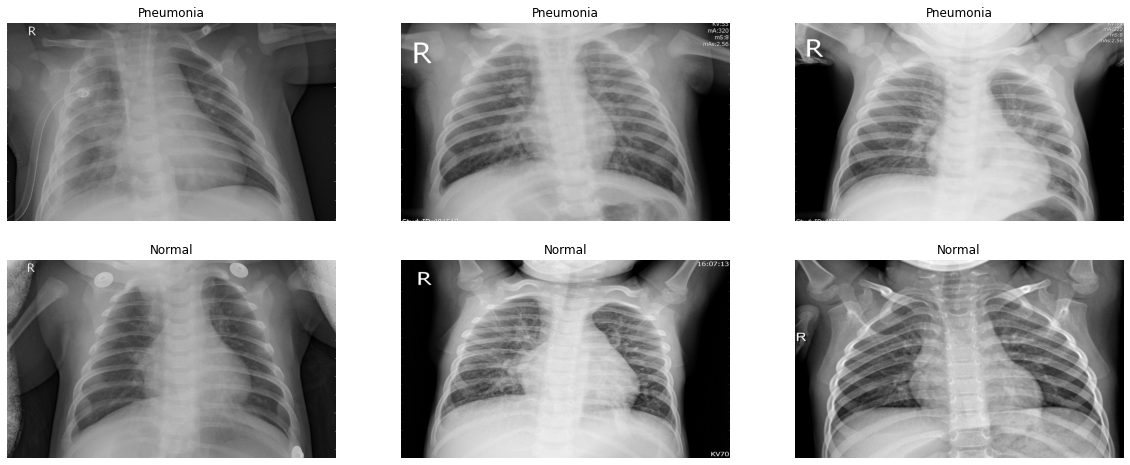

In [0]:
from skimage.io import imread
from skimage.transform import resize


# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,3, figsize=(20,8))
for i in range(6):
    img = imread(samples[i])
    ax[i//3, i%3].imshow(img, cmap='gray')
    if i<3:
        ax[i//3, i%3].set_title("Pneumonia")
    else:
        ax[i//3, i%3].set_title("Normal")
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_aspect('auto')
plt.show()



In [0]:
#PNEUMONIA: This directory contains those samples that are the pneumonia cases.
# Get the path to the normal and pneumonia sub-directories
normal_test_cases_dir = test_dir / 'NORMAL'
pneumonia_test_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
test_normal_cases = normal_test_cases_dir.glob('*.jpeg')
test_pneumonia_cases = pneumonia_test_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in test_normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in test_pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,image,label
0,/content/gdrive/My Drive/demo/chest_xray/chest...,0
1,/content/gdrive/My Drive/demo/chest_xray/chest...,0
2,/content/gdrive/My Drive/demo/chest_xray/chest...,1
3,/content/gdrive/My Drive/demo/chest_xray/chest...,1
4,/content/gdrive/My Drive/demo/chest_xray/chest...,1


1    390
0    234
Name: label, dtype: int64


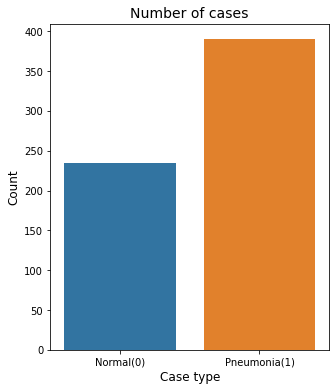

In [0]:
# Get the counts for each class
test_cases_count = test_data['label'].value_counts()
print(test_cases_count)

# Plot the results 
plt.figure(figsize=(5,6))
sns.barplot(x=test_cases_count.index, y= test_cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(test_cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()


In [0]:
# Load and augment training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/demo/chest_xray/chest_xray/train/',
    batch_size=16,
    target_size=(150, 150),
    shuffle=True,
    class_mode='categorical'
)

Found 5216 images belonging to 2 classes.


In [0]:
# Load validation and test data
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/demo/chest_xray/chest_xray/val',
    batch_size=16,
    target_size=(150, 150),
    class_mode='categorical'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
    '/content/gdrive/My Drive/demo/chest_xray/chest_xray/test',
    batch_size=16,
    target_size=(150, 150),
    class_mode='categorical'
)


Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:

from keras.applications import DenseNet169
base_model = tf.keras.applications.DenseNet169(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
base_model.trainable = False


51879936/51877672 [==============================] - 1s 0us/step


In [0]:
# Define model
def model():
    model = base_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dense(units=512, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.6)(model)
    predictions = tf.keras.layers.Dense(units=2, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [0]:
model = model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [0]:
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.562379 to fit



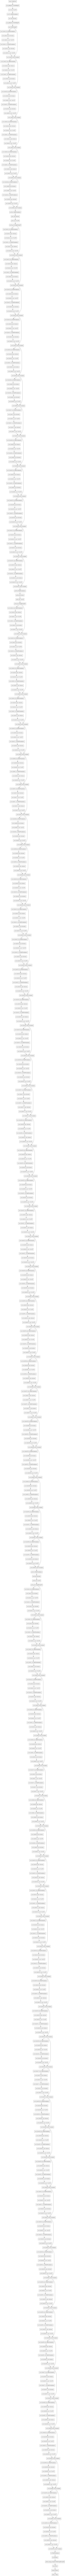

In [0]:
plot_model(model, to_file='DENSENET169.png')

In [0]:
Log = model.fit_generator(
    train_generator,
    epochs=10,
    verbose=1,
    validation_data=val_generator,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
326/326 [==============================] - 1695s 5s/step - loss: 0.3077 - accuracy: 0.9043 - val_loss: 0.5393 - val_accuracy: 0.6875
Epoch 2/10
326/326 [==============================] - 458s 1s/step - loss: 0.1828 - accuracy: 0.9248 - val_loss: 0.4593 - val_accuracy: 0.7500
Epoch 3/10
326/326 [==============================] - 461s 1s/step - loss: 0.1689 - accuracy: 0.9387 - val_loss: 0.6995 - val_accuracy: 0.6875
Epoch 4/10
326/326 [==============================] - 448s 1s/step - loss: 0.1605 - accuracy: 0.9383 - val_loss: 0.4317 - val_accuracy: 0.7500
Epoch 5/10
326/326 [==============================] - 458s 1s/step - loss: 0.1486 - accuracy: 0.9450 - val_loss: 0.4001 - val_accuracy: 0.7500
Epoch 6/10
326/326 [==============================] - 454s 1s/step - loss: 0.1463 - accuracy: 0.9461 - val_loss: 0.6917 - val_accuracy: 0.6250
Epoch 7/10
326/326 [==============================] - 455s 1s/ste

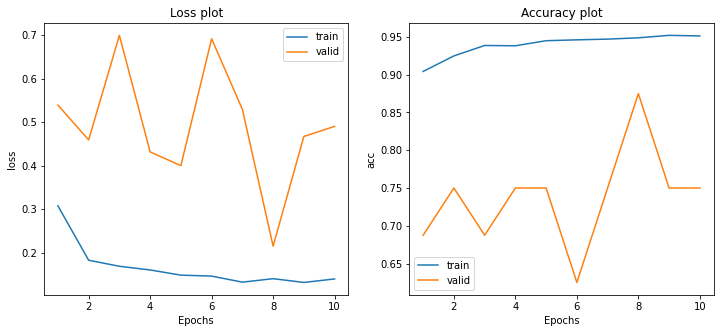

In [0]:
# plot the model loss and accuracy
train_loss = Log.history['loss']
train_acc = Log.history['accuracy']

valid_loss = Log.history['val_loss']
valid_acc = Log.history['val_accuracy']

x = [(i+1) for i in range(len(train_loss))]

f,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(x, train_loss)
ax[0].plot(x, valid_loss)
ax[0].set_title("Loss plot")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'valid'])


ax[1].plot(x, train_acc)
ax[1].plot(x, valid_acc)
ax[1].set_title("Accuracy plot")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("acc")
ax[1].legend(['train', 'valid'])

plt.show()

In [0]:
loss, test_acc = model.evaluate_generator(
    test_generator,
    steps=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    verbose=1
)

print(test_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
39/39 [==============================] - 178s 5s/step - loss: 0.5160 - accuracy: 0.8494
0.8493589758872986


In [0]:
model.save('model2.h5')

In [0]:
# Load model for testing
model = tf.keras.models.load_model('model2.h5')

test_dir = Path('/content/gdrive/My Drive/demo/chest_xray/chest_xray/test')

normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

In [0]:
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150, 150))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = tf.keras.utils.to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150, 150))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = tf.keras.utils.to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 150, 150, 3)
Total number of labels: (624, 2)


<Figure size 432x288 with 0 Axes>

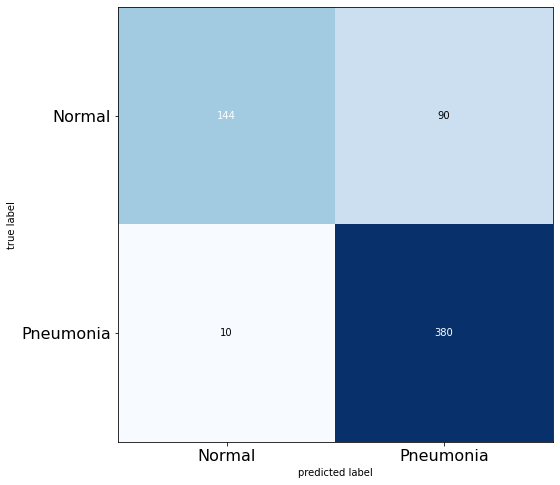

Recall of the model is 0.97
Precision of the model is 0.81
Accuracy of the model is 83.97
F1 Score of the model is 0.88


In [0]:
# Get predictions
preds = model.predict(test_data, batch_size=16)#<-
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

cm = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True,
                      cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
#F1 Score
f1 = (2*precision*recall)/(precision + recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("Accuracy of the model is {:.2f}".format(Accuracy))
print("F1 Score of the model is {:.2f}".format(f1))